## Downloading ECCO Datasets from PO.DAAC

### Initalize Python libraries

In [15]:
import numpy as np
import pandas as pd
import requests
import shutil
import time as time

# to read and plot the downloaded NetCDF files
import xarray as xr

# for concurrent simulatenous downloads
from concurrent.futures import ThreadPoolExecutor
from getpass import getpass
from http.cookiejar import CookieJar
from io import StringIO
from itertools import repeat
from pathlib import Path
from platform import system
from netrc import netrc
from os.path import expanduser, basename, isfile, isdir, join
# progress bar
from tqdm import tqdm
# library to download files
from urllib import request

# Predict the path of the netrc file depending on os/platform type.
_netrc = join(expanduser('~'), "_netrc" if system()=="Windows" else ".netrc")

### Define Helper Subroutines

#### Helper subroutine to log into NASA EarthData

In [16]:
# not pretty but it works
def setup_earthdata_login_auth(url: str='urs.earthdata.nasa.gov'):
    # look for the netrc file and use the login/password
    try:
        username, _, password = netrc(file=_netrc).authenticators(url)

    # if the file is not found, prompt the user for the login/password
    except (FileNotFoundError, TypeError):
        print('Please provide Earthdata Login credentials for access.')
        username, password = input('Username: '), getpass('Password: ')
    
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, url, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

#### Helper subroutines to make the API calls to search CMR and parse response

In [17]:
def set_params(params: dict):
    params.update({'scroll': "true", 'page_size': 2000})
    return {par: val for par, val in params.items() if val is not None}

def get_results(params: dict, headers: dict=None):
    response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.csv", 
                            params=set_params(params),
                            headers=headers)
    return response, response.headers


def get_granules(params: dict):
    response, headers = get_results(params=params)
    scroll = headers['CMR-Scroll-Id']
    hits = int(headers['CMR-Hits'])
    if hits==0:
        raise Exception("No granules matched your input parameters.")
    df = pd.read_csv(StringIO(response.text)) 
    while hits > df.index.size:
        response, _ = get_results(params=params, headers={'CMR-Scroll-Id': scroll})
        data = pd.read_csv(StringIO(response.text))
        df = pd.concat([df, data])
    return df

#### Helper subroutine to gracefully download single files and avoids re-downloading if file already exists.

In [18]:
# To force redownload of the file, pass **True** to the boolean argument *force* (default **False**)
def download_file(url: str, output_dir: str, force: bool=False):
    """
    url (str): the HTTPS url from which the file will download
    output_dir (str): the local path into which the file will download
    force (bool): download even if the file exists locally already
    """
    if not isdir(output_dir):
        raise Exception(f"Output directory doesnt exist! ({output_dir})")
    
    target_file = join(output_dir, basename(url))
    
    # if the file has already been downloaded, skip    
    if isfile(target_file) and force is False:
        print(f'\n{basename(url)} already exists, and force=False, not re-downloading')
        return 0
    
    with requests.get(url) as r:
        if not r.status_code // 100 == 2: 
            raise Exception(r.text)
            return 0
        else:
            with open(target_file, 'wb') as f:
                total_size_in_bytes= int(r.headers.get('content-length', 0))
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)

                return total_size_in_bytes

#### Helper subroutine to download all urls in the list dls

In [19]:
def download_files_concurrently(dls, download_dir, force=False):
    start_time = time.time()

    # use 3 threads for concurrent downloads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:

        # tqdm makes a cool progress bar
        results = list(tqdm(executor.map(download_file, dls, repeat(download_dir), repeat(force)), total=len(dls)))
    
        # add up the total downloaded file sizes
        total_download_size_in_bytes = np.sum(np.array(results))
        # calculate total time spent in the download
        total_time = time.time() - start_time

        print('\n=====================================')
        print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
        print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s')

### Download granules of an ECCO dataset falling within a specific date range

### Define dataset parameters

Specify ECCO dataset `ShortName`. URLs associated with the granules to download using this `ShortName`. <br>

Specify a desired date range using `StartDate` and `EndDate`. <br>

Here we look for files matching a 7-day range (inclusive), January 1, 2000 to January 7, 2000. Note, the granule associated with the daily-mean of December 31, 1999 matches the search because its `EndDate` is January 1, 2000.

In [6]:
# ECCO dataset shortname (from PODAAC)
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4"

# desired date range
StartDate = "2000-01-01"
EndDate   = "2000-01-07"

## From Ian

Dataset shortname:ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4

3D monthly-mean T and S on the lat-lon grid from ECCO V4r4
https://podaac.jpl.nasa.gov/dataset/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4

3D Grid geometry parameters for the lat-lon gridded ECCO V4r4
https://podaac.jpl.nasa.gov/dataset/ECCO_L4_GEOMETRY_05DEG_V4R4?ids=&values=&search=ecco%20grid%20lat&provider=POCLOUD

In [28]:
# ECCO dataset shortname (from PODAAC)
# ShortName = "ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4"
ShortName = "ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4"
# ShortName = "ECCO_L4_GEOMETRY_05DEG_V4R4"

# desired date range
StartDate = "1992-01-01"
# StartDate = "2017-01-01"
EndDate   = "2018-01-01"

### Define download directory

In [29]:
# define root directory for downloaded NetCDF files
download_root_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/ECCO_V4r4_PODAAC')

# define the 'download_root_dir' where the files will be saved as download_root_dir/ShortName
download_dir = download_root_dir / ShortName

# create the download directory
download_dir.mkdir(exist_ok = True, parents=True)

print(f'created new download directory {download_dir}')

created new download directory C:\Users\marie\Documents\PhD\Chapter_3\data\ECCO_V4r4_PODAAC\ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4


### Log into Earthdata using your username and password

In [30]:
# actually log in with this command:
setup_earthdata_login_auth()

### Search NASA's "Common Metadata Repository" for the ECCO dataset

Query the NASA Common Metadata Repository to find the URL of every granule associated with the desired ECCO Dataset and date range of interest.

In [31]:
# create a Python dictionary with our search criteria:  `ShortName` and `temporal`
input_search_params = {'ShortName': ShortName,
                       'temporal': ",".join([StartDate, EndDate])}

print(input_search_params)

{'ShortName': 'ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4', 'temporal': '1992-01-01,2018-01-01'}


### Query CMR for the desired ECCO Dataset

Call `get_granules` with the `input_search_params` dictionary argument. The result is a Pandas dataframe with granule metadata results in table form.

In [32]:
# grans means 'granules', PO.DAAC's term for individual files in a dataset
grans = get_granules(input_search_params)

# what did we find? --- 312 granules!
grans.info()

num_grans = len( grans['Granule UR'] )
print (f'\nTotal number of matching granules: {num_grans}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Granule UR           312 non-null    object 
 1   Producer Granule ID  0 non-null      float64
 2   Start Time           312 non-null    object 
 3   End Time             312 non-null    object 
 4   Online Access URLs   312 non-null    object 
 5   Browse URLs          0 non-null      float64
 6   Cloud Cover          0 non-null      float64
 7   Day/Night            312 non-null    object 
 8   Size                 312 non-null    float64
dtypes: float64(4), object(5)
memory usage: 22.1+ KB

Total number of matching granules: 312


## Download the granules

In [33]:
# convert the rows of the 'Online Access URLS' column to a Python list
dls = grans['Online Access URLs'].tolist()

# the url of the first file is
print(dls[0])

https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_1992-01_ECCO_V4r4_latlon_0p50deg.nc


### Method 1: Concurrent downloads

Define the maximum number of concurrent downloads (benefits typically taper off above 5-6)

In [26]:
max_workers = 6

Execute the download command

In [ ]:
# Ex 1) Force redownload if the file exists
force=True
download_files_concurrently(dls, download_dir, force)

In [34]:
# Ex 2) Do not force redownload if the file exists
force=False
download_files_concurrently(dls, download_dir, force)

100%|██████████| 312/312 [03:04<00:00,  1.69it/s]


total downloaded: 1166.22 Mb
avg download speed: 6.32 Mb/s


## Method 2: Sequential Downloads

Download each URL sequentially in a for loop.

In [12]:
total_download_size_in_bytes = 0
start_time = time.time()

# force file download for demonstration purposes
force = True

# loop through all urls in dls
for u in dls:
    u_name = u.split('/')[-1]
    print(f'downloading {u_name}')
    total_download_size_in_bytes += download_file(url=u, output_dir=download_dir, force=force)

# calculate total time spent in the download
total_time = time.time() - start_time

print('\n=====================================')
print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s')

downloading GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc

total downloaded: 1.9 Mb
avg download speed: 0.32 Mb/s


### Check downloads

Get the list of files:

In [35]:
ecco_netcdf_files = list(download_dir.glob('*nc'))

print(f'number of downloaded files {len(ecco_netcdf_files)}')

number of downloaded files 312


### Plot results

Now open and combine all NetCDF files together using the `xarray.open_mfdataset` function:

In [ ]:
ecco_netcdf_files

In [37]:
xds = xr.open_mfdataset(ecco_netcdf_files, parallel=True, data_vars='minimal',\
                                  coords='minimal', compat='override')

xds

<xarray.Dataset>
Dimensions:         (time: 312, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T...
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    EXFhl           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFhs           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFlwdn         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFswdn         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFqnet         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    oceQnet         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SIatmQnt        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    TFLUX           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFswnet        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFlwnet        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    oceQsw          (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SIaaflux        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Ocean and Sea-Ice Surface Heat Fluxes ...
    uuid:                         73ea7d5c-4158-11eb-8d61-0cc47a3f812d

In [39]:
# compute the time mean over the single year
# time_mean_SALT = xds.SALT.isel(Z=0).mean('time').compute()
time_mean_heat = xds.EXFqnet.mean('time').compute()

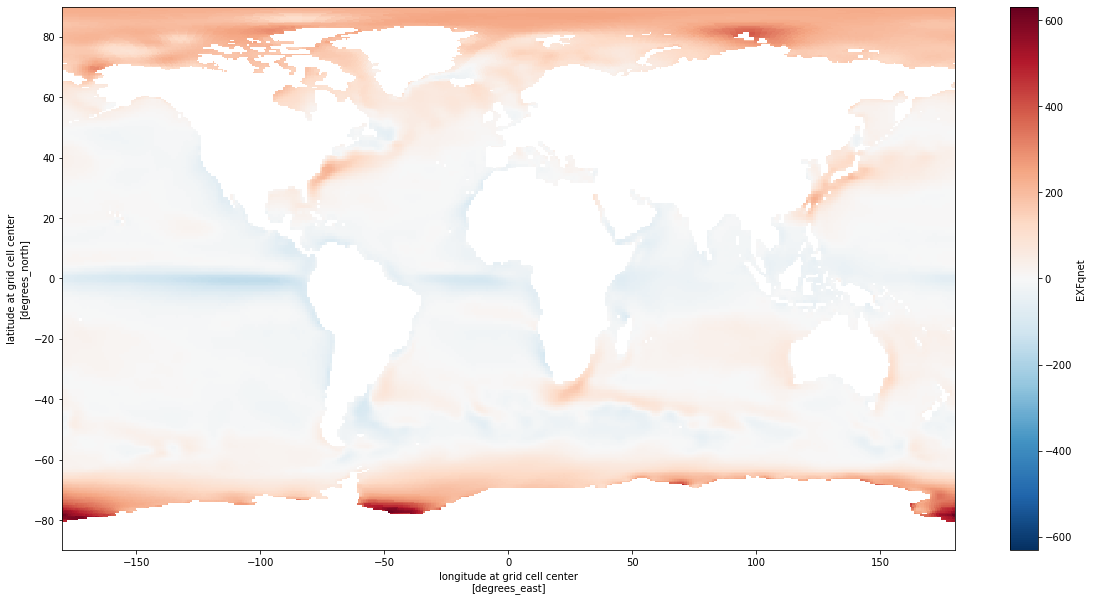

In [40]:
# time_mean_SALT.plot(figsize=[20,10])
time_mean_heat.plot(figsize=[20,10])

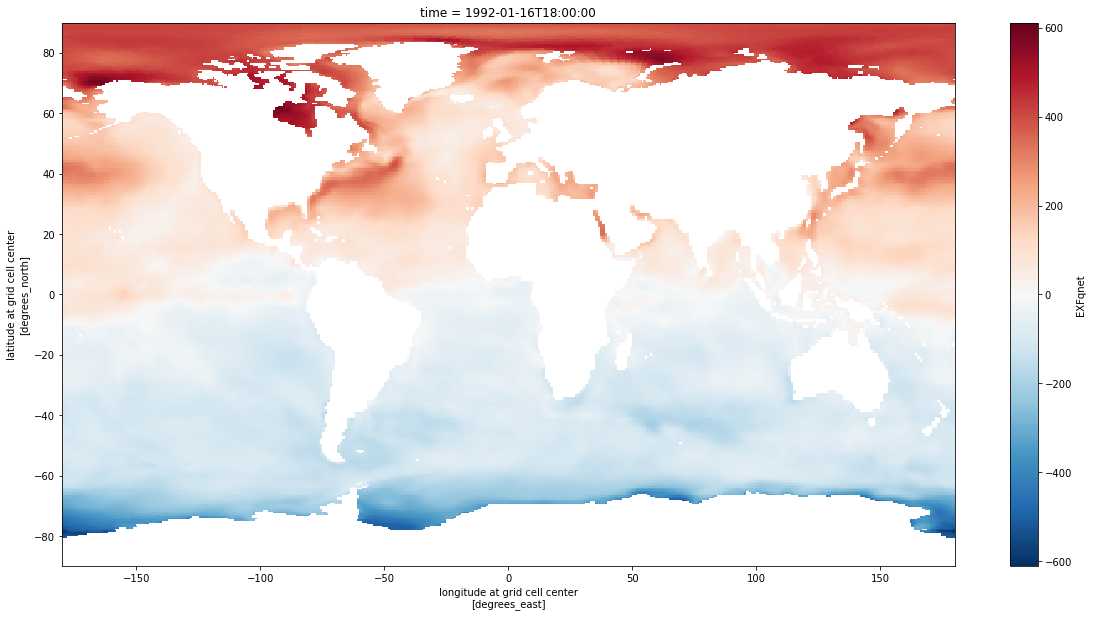

In [41]:
# Plot the anomaly of the first record relative to the time mean
# (xds.SALT.isel(Z=0,time=0) - time_mean_SALT).plot(figsize=[20,10])
(xds.EXFqnet.isel(time=0) - time_mean_heat).plot(figsize=[20,10])